# <u>Eye For Blind - Capstone Project</u>

### By - Divya Jayendrakumar Sodha

## Objective:



>*  There are many visually impaired people and it gets extremely tough for them to carry out daily activities, one of which is reading.
>
>*  In an initiative to help them experience the beauty of the images, Facebook had earlier launched a unique feature earlier that can help blind people operate the app on their mobile phones. The feature could explain the contents of an image that their friends have posted on Facebook. So, say, if someone posted a picture with their dog in the park, the application would speak out the contents and may describe it like, “This image may contain a dog standing with a man around the trees.”
>
>*  Taking an inspiration from this initiative, this project is an attempt to learn the basic architecture behind it. Here, we will convert an image to text description first, which is the central part on which the project is more focused. Then, using a simple text-to-speech API, we will extract the text description/caption and convert it to audio.
>
>*  In future scope, an attempt will be to make the model more robust and deploy the project on our local system using a Flask-based model to generate audio-based content for any image.


### Dataset Decsription

>The dataset called <u>Flickr8K dataset</u> is taken from the Kaggle website and it consists of sentence-based image descriptions having a list of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events of the image.

### Techniques Used


>*   Text and Image preprocessing
>*   Data Visualization (bar plot/ Wordcloud Map)
>*   Data preparation using Tensorflow
>*   Custom model building using Tensorflow
>*   Model training and model evaluation (INCEPTIONV3)
>*   <u>Traditional CNN-RNN model based on encoder-decoder architecture
>*   Attention model along with Teacher Forcing
>*   Greedy search vs Beam search and BLEU Score</u>





### **1. Initial Setup**

>*   Installing additional libraries (if required)
>*   Importing required libraries
>*   Fetching dataset file from kaggle and extracting it in data folder


In [ ]:
# Installing additional libraries (if required)

!pip install wordcloud
!pip install gTTs
!pip install playsound
!pip install kaggle

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Importing required libraries

import pandas as pd
import numpy as np
import os 
import glob
import re
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
import time
from skimage import io

import nltk
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model

from wordcloud import WordCloud, STOPWORDS

from gtts import gTTS
from playsound import playsound
from IPython import display

import warnings
warnings.filterwarnings("ignore")

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [ ]:
# Configuration environment
import os

os.environ['KAGGLE_USERNAME'] = "divya10sodha" # username from the json file
os.environ['KAGGLE_KEY'] = "b2fe970f1e0c3cdb555e162f3bb0f86d" # key from the json file

In [ ]:
# Data Fetching
!kaggle datasets download -d adityajn105/flickr8k

flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# importing the zipfile module
from zipfile import ZipFile  

# loading the temp.zip and creating a zip object
with ZipFile("flickr8k.zip", 'r') as zObject:  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path="./data")

### **2. Data Understanding and Visualization**

>*   Reading the images and captions in two different variables
>*   Visualizing Images and Captions in the dataset
>*   Dataframe creation to store images along with thir respective captions and path
>*   Visualizing the top 30 most occurring words in the captions (through bar plots and wordcloud map)



In [ ]:
# Importing the dataset and reading the images paths into a seperate variable

images_path='/home/capstone/data/Images/'

all_images_path = glob.glob(images_path + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_images_path)))

The total images present in the dataset: 8496


In [ ]:
# Importing the dataset and reading the text file into a seperate variable

text_file = '/home/capstone/data/captions.txt'

def load_doc(filename):    
    '''
    To read text file
    '''
    f = open(filename, "r")
    lines = f.readlines()[1:]
    f.close()
    return lines

doc = load_doc(text_file)
# print(doc[:300])

In [ ]:
# Creating a dataframe to summarize the image, path and captions

all_images_id = []
all_images_vector = []
annotations = []

for l in doc:
    all_images_vector.append(images_path + l.split(",")[0])
    all_images_id.append(l.split(".jpg,")[0])
    annotations.append(l.split(".jpg,")[1].strip("\n"))

df = pd.DataFrame(list(zip(all_images_id, all_images_vector, annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

ID                                               Path  \
0  1000268201_693b08cb0e  /home/capstone/data/Images/1000268201_693b08cb...   
1  1000268201_693b08cb0e  /home/capstone/data/Images/1000268201_693b08cb...   
2  1000268201_693b08cb0e  /home/capstone/data/Images/1000268201_693b08cb...   
3  1000268201_693b08cb0e  /home/capstone/data/Images/1000268201_693b08cb...   
4  1000268201_693b08cb0e  /home/capstone/data/Images/1000268201_693b08cb...   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

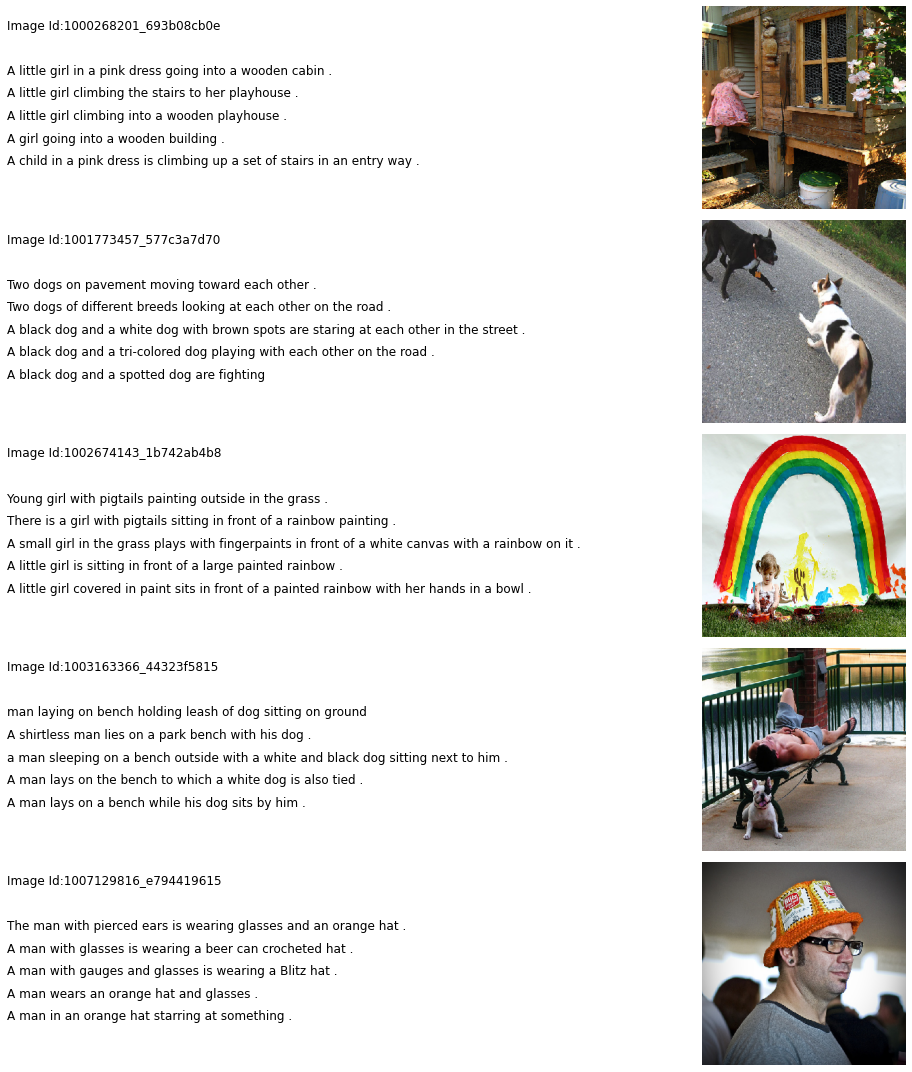

In [ ]:
# Visualising both the images & text present in the dataset

fig = plt.figure(figsize=(15,15)) # For dosplaying image
count = 1
    
for Path in df[:25].Path.unique(): # Loading 1st 25 paths which will have 5 distinct images
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(5,2,count) #Adding a subplot that spans 5 rows:
    plt.axis('off')  # we don't want both x and y axes for caption 
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(-2,len(captions)+2) #to decide the spacing between each line of caption

    ax.text(0,6,"Image Id:" + df["ID"].loc[df.Path== Path].values[0], fontsize=12)
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=12)  #to display the captions         
    count+=1
    plt.tight_layout() #to make sure that image and caption don't overlap

    ax = fig.add_subplot(5,2,count)
    ax.imshow(display_image)
    plt.axis('off')
    count +=1

plt.show()  

In [ ]:
# Creating a list which contains all the captions
# Adding the <start> & <end> token to all those captions as well
annotations_list = df.Captions.apply(lambda x:'<start> '+ x + ' <end>').to_list()

#Creating a list which contains all the path to the images
all_img_path_list= df.Path.tolist()

print("Total captions present in the dataset: "+ str(len(annotations_list)))
print("Total images present in the dataset: " + str(len(all_img_path_list)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [ ]:
# Creating the vocabulary & the counter for the captions

vocabulary = [word for line in annotations_list for word in line.split()]    
val_count = Counter(vocabulary)
val_count.most_common(30)

[('<start>', 40455),
 ('<end>', 40455),
 ('a', 40271),
 ('.', 34212),
 ('A', 21481),
 ('in', 18961),
 ('the', 15328),
 ('on', 10729),
 ('is', 9345),
 ('and', 8850),
 ('dog', 7982),
 ('with', 7760),
 ('man', 6828),
 ('of', 6712),
 ('Two', 3962),
 ('white', 3875),
 ('black', 3696),
 ('are', 3503),
 ('boy', 3442),
 ('woman', 3227),
 ('girl', 3217),
 (',', 3210),
 ('to', 3173),
 ('wearing', 3061),
 ('The', 2920),
 ('at', 2904),
 ('water', 2774),
 ('red', 2660),
 ('brown', 2475),
 ('people', 2442)]

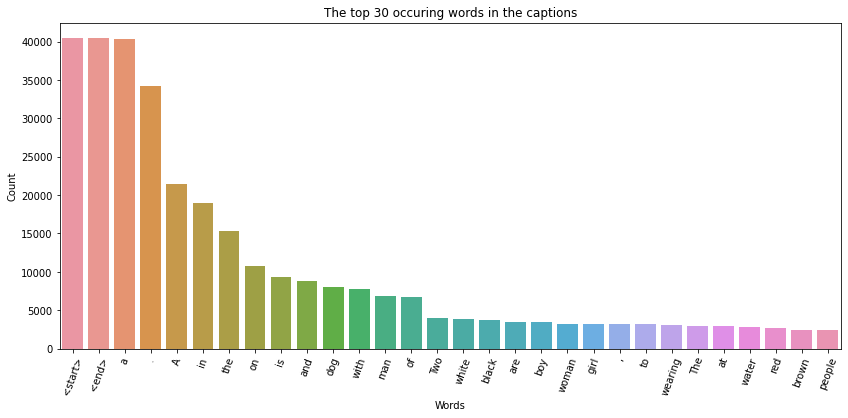

In [ ]:
# Visualising the top 30 occuring words in the captions

plt.figure(figsize=(14,6))
most_co_30 = val_count.most_common(30)
x, y = zip(*most_co_30)

sns.barplot(x=np.array(x), y=np.array(y))

plt.xlabel("Words")
plt.ylabel("Count")
plt.title("The top 30 occuring words in the captions")
plt.xticks(rotation=70)
plt.show()

### **3. Data Cleaning**

>*   Converting captions to lowercase
>*   Removing punctuations (through stopwords)
>*   Removing numeric values and retain words in captions (through stopwords)


##### <u>As we can see that "a" and "A", "the" and "The" both are included and so on. So we will lower the case because our model dosent required to identify upper and lower case.</u>

In [ ]:
vocabulary_lower = list(map(lambda x: x.lower(), vocabulary))

In [ ]:
val_count_lower = Counter(vocabulary_lower)
val_count_lower.most_common(30)

[('a', 61752),
 ('<start>', 40455),
 ('<end>', 40455),
 ('.', 34212),
 ('in', 18965),
 ('the', 18249),
 ('on', 10732),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8126),
 ('with', 7761),
 ('man', 7238),
 ('of', 6712),
 ('two', 5224),
 ('white', 3935),
 ('black', 3825),
 ('boy', 3561),
 ('are', 3504),
 ('woman', 3385),
 ('girl', 3320),
 (',', 3210),
 ('to', 3173),
 ('wearing', 3061),
 ('at', 2905),
 ('people', 2856),
 ('water', 2779),
 ('red', 2672),
 ('young', 2607),
 ('brown', 2549),
 ('an', 2399)]

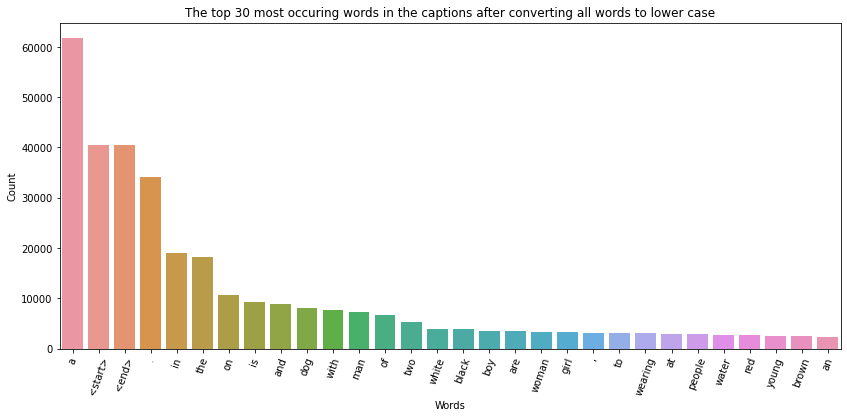

In [ ]:
plt.figure(figsize=(14,6))
most_co_30 = val_count_lower.most_common(30)
x, y = zip(*most_co_30)

sns.barplot(x=np.array(x), y=np.array(y))

plt.xlabel("Words")
plt.ylabel("Count")
plt.title("The top 30 most occuring words in the captions after converting all words to lower case")
plt.xticks(rotation=70)
plt.show()

In [ ]:
# Fetching all the unique stopwords
stopwords = set(STOPWORDS)

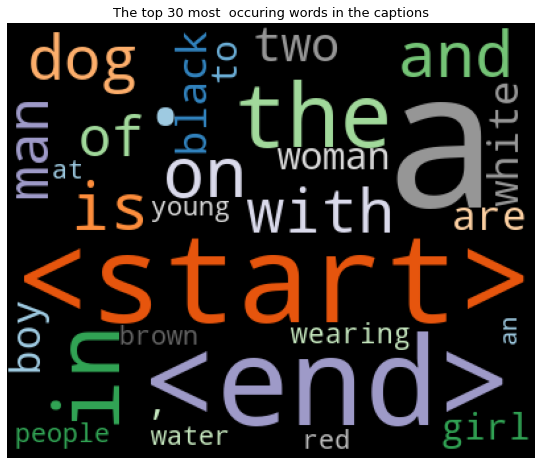

In [ ]:
def generate_wordcloud(data, title, maximum_words):
    """
    To gererate wordcloud graph.
    """
    cloud = WordCloud(width=400,
                      height=330,
                      max_words=maximum_words,
                      colormap='tab20c',
                      stopwords=stopwords,
                      collocations=False
                     ).generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title, fontsize=13)
    plt.show()
    
#Use the function to generate the word cloud
generate_wordcloud(val_count_lower, 'The top 30 most  occuring words in the captions', maximum_words=30)

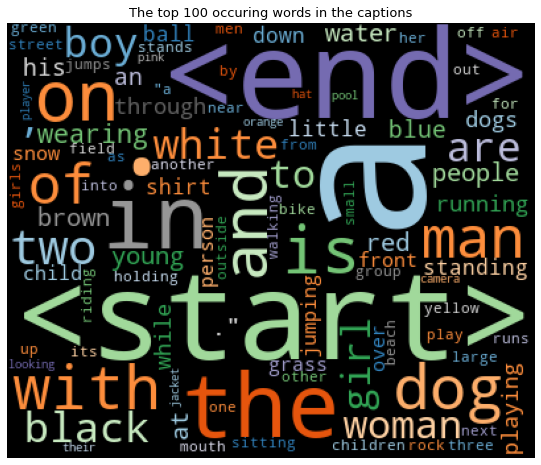

In [ ]:
# Using the same function to generate the word cloud for 100 stopwords
generate_wordcloud(val_count_lower, 'The top 100 occuring words in the captions', maximum_words=100)

### **4. Data Preprocessing**

### **4.1. Captions Preprocessing**

>*   Creating tokenizer (including removing spaces and punctuation and retaining the unique words)
>*   Replacing words beyond count of 5000 with tag : UNK <u>(for saving memory)</u>
>*   Creating word-to-index and index-to-word mappings used for later purpose
>*   Viewing words after tokenizing and text processing
>*   Padding sequences to be of same length (as that of the longest)




In [ ]:
print("We have total of ", len(val_count_lower), ": different words in the Text Corpus")

print("But we are going to keep only top 5000 words of vocabulary due to memory constraints and replace all the other words with the unknown token UNK.")

We have total of  9182 : different words in the Text Corpus
But we are going to keep only top 5000 words of vocabulary due to memory constraints and replace all the other words with the unknown token UNK.


In [ ]:
# Creating the tokenizer

max_vocaublary = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocaublary, 
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(annotations_list)
text_sequences = tokenizer.texts_to_sequences(annotations_list) 

In [ ]:
print("Length of text_sequences: ",len(text_sequences))

Length of text_sequences:  40455


In [ ]:
# Visualizing texts_to_sequences (i.e. text along with its id in tokenizer)

for i in range(3):
    print(text_sequences[i:i+1])
    print(annotations_list[i:i+1], "\n")

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>'] 

[[3, 2, 20, 317, 65, 2, 197, 118, 4]]
['<start> A girl going into a wooden building . <end>'] 

[[3, 2, 41, 20, 120, 65, 2, 197, 2438, 4]]
['<start> A little girl climbing into a wooden playhouse . <end>'] 



In [ ]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
len(tokenizer.word_counts)

8495

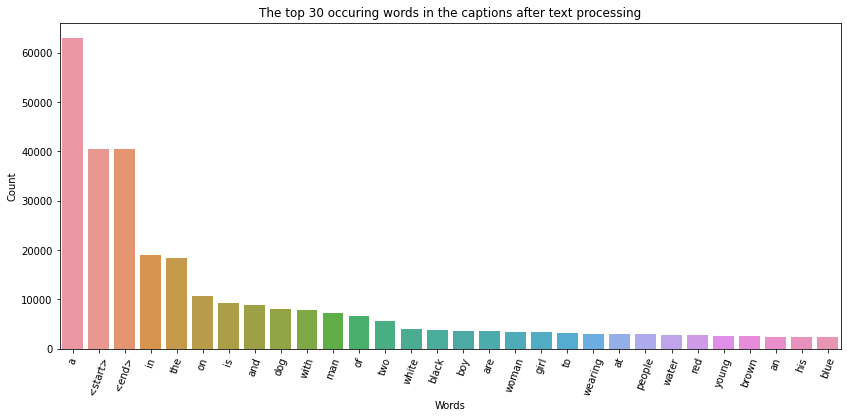

In [ ]:
# Creating a word count of our tokenizer to visulize the Top 30 occuring words after text processing

plt.figure(figsize=(14,6))
most_co_30 = sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse= True)[:30]
x, y = zip(*most_co_30)

sns.barplot(x=np.array(x), y=np.array(y))

plt.xlabel("Words")
plt.ylabel("Count")
plt.title("The top 30 occuring words in the captions after text processing")
plt.xticks(rotation=70)
plt.show()

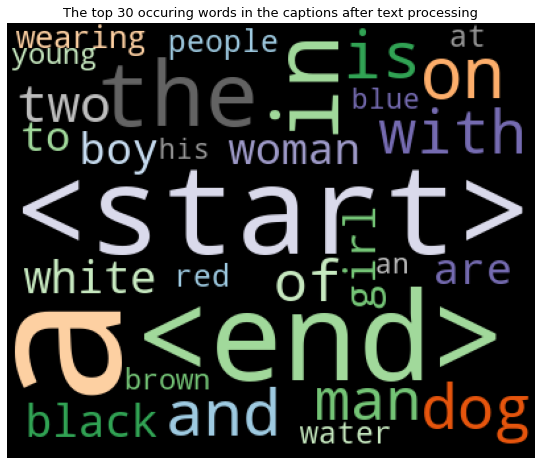

In [ ]:
# Using the function to generate the word cloud

most_common_30_words = dict(sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse= True)[:30])
generate_wordcloud(most_common_30_words, 'The top 30 occuring words in the captions after text processing', maximum_words=30)

In [ ]:
# Getting the maximum len of sentence from the caption
max_sequence_length = max(len(i) for i in text_sequences)
print(f"The maximum sequence length is: {max_sequence_length}")

# Padding each vector to the maximum length of the captions in a sentence and storing it to a vairable
caption_vector = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, padding='post', maxlen=max_sequence_length)
print("The shape of Caption vector is :" + str(caption_vector.shape))

The maximum sequence length is: 39
The shape of Caption vector is :(40455, 39)


### **4.2. Images Preprocessing**
>Defining the function for following:
>
>*   Resize images to shape : (299, 299)
>*   Normalize the image within the range of -1 to 1
>* <u>(This is the desired format for InceptionV3)<u>


In [ ]:
def preprocess_the_image(file_path):
    """
    Processing an image to the format required for Inception V3 
    """
    img = tf.io.read_file(file_path)
    # setting image channel as 3
    img = tf.image.decode_jpeg(img, channels=3)
    # resizing the image to (299,299)
    img = tf.image.resize(img, (299, 299))
    # preprocessing the image using inception_v3 (Normalizing within range -1 and 1)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img,file_path

print(f"Size of image before preprocessing: {Image.open(all_images_vector[0]).size}")
print(f'Size of image after preprocessing: {preprocess_the_image(all_images_vector[0])[0].shape}')

Size of image before preprocessing: (375, 500)
Size of image after preprocessing: (299, 299, 3)


2023-04-26 03:02:06.920470: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-04-26 03:02:06.920537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


>* Inception v3 is a widely-used image recognition model that has been shown to attain greater than about 78% accuracy on the ImageNet dataset
>
>* The model is the culmination of many ideas developed by multiple researchers over the years.
>
>* The model itself is made up of symmetric and asymmetric building blocks, including convolutions, average pooling, max pooling, concatinations, dropouts, and fully connected layers. 
>
>* Batch normalization is used extensively throughout the model and applied to activation inputs. Loss is computed using Softmax.

In [ ]:
# Mapping each image full path including name to the function to preprocess the image

# Sorting and storing unique path in list which will be given as input 
training_list = sorted(set(all_images_vector)) 

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)

# Mappng preprocess_images_function across the elements of the above dataset.
# num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
New_Image_Data = New_Image_Data.map(preprocess_the_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 64. Thus setting the value of drop_remainder as False. 
New_Image_Data= New_Image_Data.batch(64, drop_remainder=False)

### **5. Data Creation** 

>*   Applying train_test_split on both image path & captions to create the train & test list. 
>*   Creating a builder function to create train & test dataset & transform the dataset
>*   Loading the pretrained Imagenet weights of Inception net V3
>*   Shuffle and create batch while building the dataset
>*   Checking shapes of each image and caption in the dataset

#### **5.1 Train-Test Split**

In [ ]:
path_train, path_test, cap_train, cap_test = train_test_split(all_images_vector, caption_vector, test_size=0.2, random_state=42)

In [ ]:
print("Count of images in Training data: " + str(len(path_train)))
print("Count of images in Testing data: " + str(len(path_test)))
print("Count of captions in Training data: " + str(len(cap_train)))
print("Count of captions in Testing data: " + str(len(cap_test)))

Count of images in Training data: 32364
Count of images in Testing data: 8091
Count of captions in Training data: 32364
Count of captions in Testing data: 8091


#### **5.2 Loading the pretrained Imagenet weights of Inceptionnet-V3**

In [ ]:
# Loading the InceptionV3 model.
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# getting the input layer of InceptionV3() model: (None, None, None, 3)
new_input = image_model.input 
# getting the output layer of InceptionV3() model: (None, None, None, 2048)
hidden_layer = image_model.layers[-1].output 

print("Shape of Input:" , new_input.shape)
print("Shape of Output:", hidden_layer.shape)

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) 

Shape of Input: (None, None, None, 3)
Shape of Output: (None, None, None, 2048)


In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

#### **5.3 Dataset creation**

>**Note:** We can store the features in following ways:
>* Using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR 
>* Using numpy(np.save) to store the resulting vector.
>
>We are going to use the dictionary for this purpose due to memory constraints


In [ ]:
# Extracting features from each image in the dataset
image_features_dict={}
for image, image_path in tqdm(New_Image_Data): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3])) ## We are sqeezing/squashing 
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()

100%|██████████| 127/127 [00:30<00:00,  4.17it/s]


In [ ]:
# Creating a function which maps the image path to their feature.

def model_input(image,captions):
    '''
    This function will take the image_path & caption and return it's feature & respective caption.
    Input : Image_path and caption
    Output: Feature & respective caption
    '''
    image_final = image_features_dict[image.decode('utf-8')]
    return image_final, captions

In [ ]:
# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000 #1000 #500

# Batch size
BATCH_SIZE = 64 # Experimented with different batch sizes. Kernal is dieing for 32, so fixed 64 since it should be in power of 2 due to computation constraints.

def data_generator(images_data, captions_data):
    '''
    Function to create batches by combining consecutive elements of the dataset.
    '''
    
    # Creating a Dataset using tf.data.Dataset.from_tensor_slice 
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    # num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(model_input, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    # We don't want to drop the last batch if it contains element less than 64. So, just setting drop_remainder=False 
    # Prefetch function is used to prepare later elements while the current element is being processed.
    
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    ) 

    return dataset

In [ ]:
# Generating Train and Test Dataset

train_dataset=data_generator(path_train, cap_train) 
test_dataset=data_generator(path_test,cap_test) 

In [ ]:
# Checking the shapes of the train dataset

sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


### **6. Model Building** 

>*  Setting the Hyperparameters
>*  Building Encoder, Attention Model and Decoder using the concept of **Tensorflow subclassing**



#### **6.1 Setting Hyperparameters**

In [ ]:
# Setting Hyperparameters

BATCH_SIZE = 64
embedding_dim = 256 
units = 512 
vocab_size = 5001 #top 5,000 words +1 (plus 1 because of <pad>)

train_num_steps = len(path_train) // BATCH_SIZE 
test_num_steps = len(path_test) // BATCH_SIZE 

max_length=39
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

#### **6.2 Encoder (CNN)**
>* The encoder parts involve the convolution of the input image with the help of various convolution, max pooling, and fully connected layers. 
>
>*  Since we are not dealing with the classification of the image, we have removed them from the end. 
>
>*  The final output of the encoder part will be the generation of the feature vector.

In [ ]:
class Encoder(tf.keras.Model):
    '''
    To generate the feature vector
    '''
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) 
        # It acts as the fully connected layer
        
    def call(self, features):
        features = self.dense(features) # Extracting the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, threshold=0) # Applying relu activation 
        return features

In [ ]:
encoder=Encoder(embedding_dim)

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### **6.3 Attention Model**
>* Attention is an interface connecting the encoder and decoder that provides the decoder with information from every encoder hidden state.
>
>* With this framework, the model is able to selectively focus on valuable parts of the input sequence and hence, learn the association between them.
>
>* The attention model produces an output(context vector) that is fed to the decoder for predicting the word at that timestamp. This output, i.e context vector is adaptive in nature and change for each timestamp.
>
>* It aims to overcome the limitation of traditional CNN-RNN based models. Using this, instead of passing the complete input image to the RNN at every timestamp, we can pass different relevant parts of the image to it.
>
>* This makes the model faster and increase it's prediction accuracy.



In [ ]:
class Attention_model(tf.keras.Model):
    '''
    BATCH_SIZE = 64 
    embedding_dim = 256 
    units = 512 
    vocab_size = 5001 
    '''
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) # Building final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, axis=1) # Expanding the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V(tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))) # Building score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(score, axis=1) # Extracting attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: Creating the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # Reducing the shape to (batch_size, embedding_dim)
        
        return context_vector, attention_weights


>**Note:**
>1. Attention model does a linear transformation of input. Hence we have aplied tanh on top of it, in order to introduce non-linearities and achieve a smoother distribution.
>
>2. The features produced from fully connected dense layer of encoder and the hidden state of decoder are fed to tanh function and attention score is calculated
>
>3. As we require an output in range (0,1), we will apply softmax function to attention score and get the final attention weights

#### **6.4 Decoder (RNN based GRU)**
>* Input to GRU : Context vector (from attention model) concatenated with embedded vector (embedding layer). Output of this concatenation layer is fed to GRU as input
>
>* Embedding layer present inside the decoder takes the input sequence (preprocessed and transformed such that all samples have equal sequence length through padding followed by masking). Embedding layer transforms this into an embedded vector.
>
>* Concatenation layer contains : Embedded vector (output of embedding layer) along with the Context vector (output of attention model)

In [ ]:
class Decoder(tf.keras.Model):
    '''
    BATCH_SIZE = 64 
    embedding_dim = 256 
    units = 512 
    vocab_size = 5001 
    '''
    
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) # Iniitalising our Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) # Building our Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) # Building our Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) # Building our Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5) # Build our Dropout layer
        

    def call(self,x,features, hidden): 

        context_vector, attention_weights = self.attention(features, hidden) # Creating context vector & attention weights from attention model
        embed = self.embed(x) # Embeding input to shape: (batch_size, 1, embedding_dim)
#         embed = self.dropout(self.embed(x))
        embed = tf.concat([tf.expand_dims(context_vector, axis=1), embed], axis=-1) # Concatenating input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extracting the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # Shape : (batch_size * max_length, vocab_size)                  
        return output,state, attention_weights
    

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
   

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predictions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predictions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


### **7. Model Training and Optimization** 

>*  Setting the optimizer and loss object
>*  Generating checkpoint path 
>*  Generating training and testing step functions
>*  Generating loss function for the test dataset



In [ ]:
# Setting the optimizer & loss object

# Generating custom optimizer to reduce the difference between Training and Testing Loss occured due to Teacher Forcing.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000, #10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE) # loss object

In [ ]:
def loss_function(real, pred):
    '''
    Calculates loss
    '''
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

>**Reason for using Masking-**
>* Padding can result in a risk of adding penalty to the model. Once the padding is done, we need to apply 'masking'.
>* Without masking, the model will consider the padded input at that timestep, which will contribute to an increased loss.
>* Through masking we need to inform the model to ignore whenever a padded input is passed at a timestep, hinting that this part of the input is padded.
>* We apply masking to rectify the same and this will truncate down all the added penalties back to zero :
>
>Loss = Loss * Mask

In [ ]:
checkpoint_path = "/home/capstone/checkpoints/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

>While creating the training step for the model, we will apply Teacher Forcing.
>
>**Reason for using the Teacher Forcing-**
>
>* There are multiple issues with training the recurrent neural networks that use output from prior time steps as input :
    1. Slow convergence
    2. Model instability
    3. Poor skill
>
>
>* If the previous output is incorrect (by any chance), it will result in inaccurate input for the next time stamp which will further result in a different output than expected and the process will continue.
>
>* As a result, the model will get off track and will get punished for every subsequent word it generates. This makes learning slower and the model unstable.
>
>* To address this we use Teacher Forcing
>
>* Teacher Forcing is a fast and effective way to train a recurrent neural network, where the target/real word (i.e ground truth) is passed as the next input to the decoder instead of previous prediciton or output.
>
>* Training with Teacher Forcing converges faster. At the early stages of training, the predictions of the model are very bad.
>
>* If we do not use Teacher Forcing, the hidden states of the model will be updated by a sequence of wrong predictions, errors will accumulate, and it is difficult for the model to learn from that.

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    # hidden:  (64, 512) [batch, unit] 
    hidden = decoder.init_state(batch_size=target.shape[0]) # batch_size=64
    
    # dec_input:  (64, 1) [batch, 1]
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    # is used to computes the gradient using operations recorded in context of this tape.
    with tf.GradientTape() as tape:
        # getting the feature from encoder model
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]): # target shape:(64, 39)
            # running decoder() to give "predicted word" and hidden;
            
            # where "hidden" is used again for Attention_model(features, hidden).
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            # predictions shape:(64, 5001)
            loss += loss_function(target[:,i], predictions)
            
            # using teacher forcing, 
            # where we will feed the ground truth insteed of its prediction to its GRU model
            dec_input = tf.expand_dims(target[:, i], 1)
        
    #CAlculating the average loss
    avg_loss = (loss / int(target.shape[1])) # target shape:(64, 39)
    # getting total trainable_variables 
    total_trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    # to calculate gradients with respect to every trainable variable
    gradients = tape.gradient(loss, total_trainable_variables)

    # compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(gradients, total_trainable_variables))

    return loss, avg_loss

>* **While creating the test step for our model, we will pass the previous prediciton as the next input to the decoder.**

---



In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):# target shape:(64, 39)
        # running decoder() to give "predicted word" and hidden;
        # where "hidden" is used again for Attention_model(features, hidden).
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:,i], predictions)

        # not using teacher forcing on test data, 
        # where we will feed the prediction to its GRU model
        predicted_id = tf.argmax(predictions,1)
        dec_input = tf.expand_dims(predicted_id, 1)
        
    # Calculating the average loss
    avg_loss = (loss / int(target.shape[1])) # target shape:(64, 39)

    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    '''
    Calculating test loss and return the average test loss
    '''
    total_loss = 0
    
    for (batch, (img_tensor,target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss = total_loss/test_num_steps
    return avg_test_loss 

#### **Model Training**

In [ ]:
# Training the model

loss_plot = []
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        # sending one batch of image at the time 
        # batch:0-64, img_tensor:(64, 64, 2048), target:(64, 39)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss) 
    
    # Running test    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  5%|▌         | 1/20 [02:48<53:13, 168.09s/it]

For epoch: 1, the train loss is 1.692, & test loss is 1.647
Time taken for 1 epoch 167.93573713302612 sec

Test loss has been reduced from 100.000 to 1.647


 10%|█         | 2/20 [03:51<31:54, 106.37s/it]

For epoch: 2, the train loss is 1.567, & test loss is 1.540
Time taken for 1 epoch 63.01825308799744 sec

Test loss has been reduced from 1.647 to 1.540


 15%|█▌        | 3/20 [04:54<24:35, 86.82s/it] 

For epoch: 3, the train loss is 1.495, & test loss is 1.519
Time taken for 1 epoch 63.47139024734497 sec

Test loss has been reduced from 1.540 to 1.519


 20%|██        | 4/20 [05:56<20:28, 76.76s/it]

For epoch: 4, the train loss is 1.446, & test loss is 1.495
Time taken for 1 epoch 61.28145480155945 sec

Test loss has been reduced from 1.519 to 1.495


 25%|██▌       | 5/20 [06:55<17:39, 70.65s/it]

For epoch: 5, the train loss is 1.387, & test loss is 1.437
Time taken for 1 epoch 59.7231764793396 sec

Test loss has been reduced from 1.495 to 1.437


 30%|███       | 6/20 [07:58<15:52, 68.01s/it]

For epoch: 6, the train loss is 1.332, & test loss is 1.591
Time taken for 1 epoch 62.88152837753296 sec



 35%|███▌      | 7/20 [09:01<14:21, 66.28s/it]

For epoch: 7, the train loss is 1.289, & test loss is 1.503
Time taken for 1 epoch 62.72942018508911 sec



 40%|████      | 8/20 [10:04<13:02, 65.24s/it]

For epoch: 8, the train loss is 1.243, & test loss is 1.580
Time taken for 1 epoch 62.99582839012146 sec



 45%|████▌     | 9/20 [11:07<11:50, 64.59s/it]

For epoch: 9, the train loss is 1.195, & test loss is 1.656
Time taken for 1 epoch 63.16402864456177 sec



 50%|█████     | 10/20 [12:09<10:35, 63.59s/it]

For epoch: 10, the train loss is 1.169, & test loss is 1.666
Time taken for 1 epoch 61.336256980895996 sec



 55%|█████▌    | 11/20 [13:10<09:26, 62.92s/it]

For epoch: 11, the train loss is 1.123, & test loss is 1.804
Time taken for 1 epoch 61.39014768600464 sec



 60%|██████    | 12/20 [14:13<08:22, 62.87s/it]

For epoch: 12, the train loss is 1.092, & test loss is 1.756
Time taken for 1 epoch 62.7559597492218 sec



 65%|██████▌   | 13/20 [15:16<07:21, 63.02s/it]

For epoch: 13, the train loss is 1.068, & test loss is 1.733
Time taken for 1 epoch 63.37446188926697 sec



 70%|███████   | 14/20 [16:18<06:15, 62.58s/it]

For epoch: 14, the train loss is 1.047, & test loss is 1.862
Time taken for 1 epoch 61.55574369430542 sec



 75%|███████▌  | 15/20 [17:20<05:11, 62.39s/it]

For epoch: 15, the train loss is 1.028, & test loss is 1.810
Time taken for 1 epoch 61.95312309265137 sec



 80%|████████  | 16/20 [18:21<04:08, 62.03s/it]

For epoch: 16, the train loss is 1.014, & test loss is 1.865
Time taken for 1 epoch 61.17972159385681 sec



 85%|████████▌ | 17/20 [19:23<03:06, 62.21s/it]

For epoch: 17, the train loss is 0.995, & test loss is 1.820
Time taken for 1 epoch 62.63602161407471 sec



 90%|█████████ | 18/20 [20:25<02:03, 61.98s/it]

For epoch: 18, the train loss is 0.981, & test loss is 2.001
Time taken for 1 epoch 61.440996408462524 sec



 95%|█████████▌| 19/20 [21:28<01:02, 62.32s/it]

For epoch: 19, the train loss is 0.965, & test loss is 1.808
Time taken for 1 epoch 63.10223460197449 sec



100%|██████████| 20/20 [22:29<00:00, 67.49s/it]

For epoch: 20, the train loss is 0.951, & test loss is 1.977
Time taken for 1 epoch 61.24457669258118 sec



#### **Plotting Loss Function**

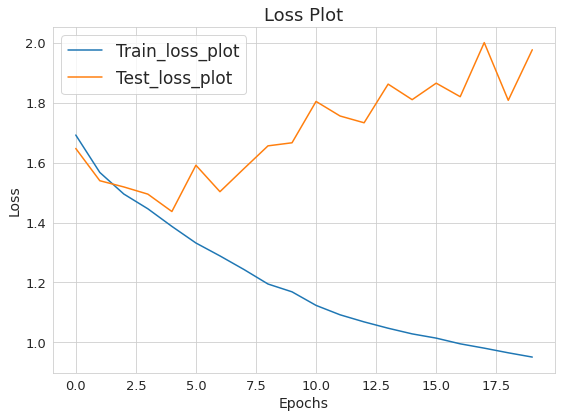

In [ ]:
plt.figure(figsize=(8,6), tight_layout=True)
sns.set_style("whitegrid")
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=17)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

plt.plot(loss_plot, label ='Train_loss_plot')
plt.plot(test_loss_plot, label ='Test_loss_plot')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

>**NOTE :**
>* Since there is a difference between the train & test steps (Presence of teacher forcing), we observe that the train loss is decreasing while our test loss is not.
>
>* We can improve this model by using techniques like data augmentation and running for more number of epochs. We have already applied buffer and learning rate decay approaches.

### **8 Model Evaluation**

### **8.1 Greedy Search**

>*   This method is a simple approximation technique which calculates the probability of the words according to their occurrence in the English vocabulary.
>
>*   It takes the sample of the words, finds the probability of each of the words, and then outputs the word with the highest probability.
>
>*   Greedy Search will always consider only one best alternative and this makes the computational speed of the model fast, but the accuracy might not be up to the mark.



In [ ]:
def evaluate(image):
    '''
    Evaluates our prediction using greedy search
    '''
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.init_state(batch_size=1)
    
    # Processing the input image to desired format before extracting features
    temp_input = tf.expand_dims(preprocess_the_image(image)[0], 0) 
    # Extracting features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # Extracting the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
       # Getting the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        # Extracting the predicted id(embedded value) which carries the max value
        predicted_id =  tf.argmax(predictions[0]).numpy() 
        # Mapping the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id]) 

        # Signalling the end of the caption if the predicted word is <end>
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

In [ ]:
def plot_attmap(caption, weights, image):
    '''
    Plotting the image 
    '''
    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
def filt_text(text):
    '''
    Filters the words used for processing but not required at this stage. 
    '''
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
img_test=path_test.copy()

In [ ]:
def best_score_bleu(reference, candidate, weights):
    '''
    To calculate best bleu score
    '''
    best_score = sentence_bleu(reference, candidate, weights=weights)
    weights_list = [(1,0,0,0), (0,1,0,0), (0,0,1,0), (0,0,0,1), (0.5, 0.5, 0, 0), 
                    (0.5, 0.25, 0, 0), (0.35, 0.25, 0, 0), (0.25, 0.5, 0, 0)]
    
    best_weights = weights
    name_o_score = [" 1-Gram", " 2-Gram", " 3-Gram", " 4-Gram", "Random-1",
                   "Random-2", "Random3", "Random-4", "Random-5"]
    best_weight_type = "Random"
    
    
    for i in range(5):
        score = sentence_bleu(reference, candidate, weights=weights_list[i])
        print("Type="+name_o_score[i]+", Weight="+str(weights_list[i])+ ", Score="+str(score))
        if score > best_score:
            best_score=score
            best_weights=weights_list[i]
            best_weight_type=name_o_score[i]
            
    print("\nBest weight type=", best_weight_type)
    print("Best weight=", best_weights)
    return best_score        

In [ ]:
# Modifying the given code as function to run it several times by changing weights

def predicted_caption_audio(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):
    '''
    Converts the predicted text to audio and we can also play it.
    '''
    cap_test2=cap_test.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test2[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = best_score_bleu(reference, candidate, weights=weights)
    print(f"Best BLEU score (in%): {score*100}")

    print ('\nReal Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    #Using Google Text to Speech Online API from playing the predicted caption as audio
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    display.display(display.Audio(audio_file, rate=None,autoplay=False))
    
    return test_image

>##### **The evaluation metrics which we are using is BLEU (Bilingual Evaluation Understudy)**
>*  BLEU is a well-acknowledged metric to measure similarity of one hypothesis sentence to multiple reference sentences. Given a single hypothesis sentence and multiple reference sentences, it returns a value between 0 and 1. 
>
>* The metric close to 1 means that the two are very similar.
>
>* The BLEU is simply taking the fraction of n-grams in the predicted sentence that appears in the ground-truth.

#### Image 1

Type= 1-Gram, Weight=(1, 0, 0, 0), Score=0.2021768865708778
Type= 2-Gram, Weight=(0, 1, 0, 0), Score=1.3495755153097447e-308
Type= 3-Gram, Weight=(0, 0, 1, 0), Score=1.3495755153097447e-308
Type= 4-Gram, Weight=(0, 0, 0, 1), Score=1.3495755153097447e-308
Type=Random-1, Weight=(0.5, 0.5, 0, 0), Score=5.223533056060786e-155

Best weight type=  1-Gram
Best weight= (1, 0, 0, 0)
Best BLEU score (in%): 20.21768865708778

Real Caption: a professional motorcycle racer raises his arm in victory
Prediction Caption: a man is riding a motorcycle


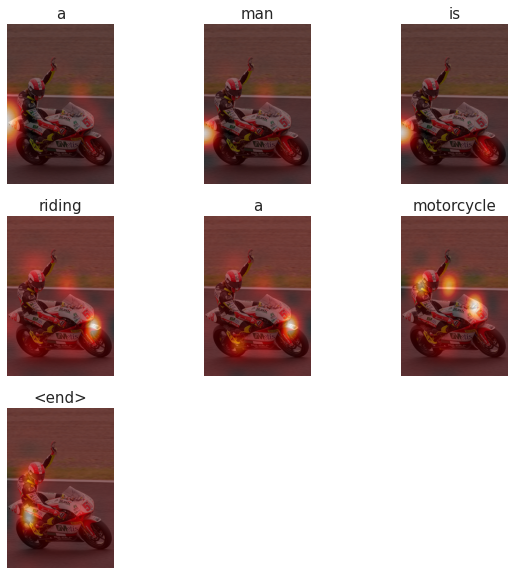

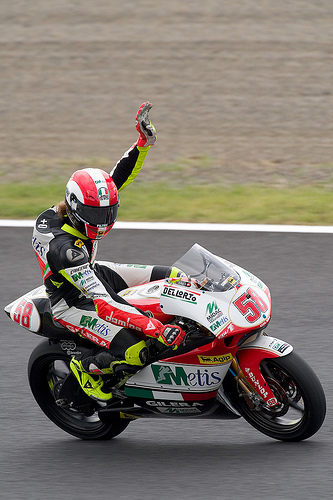

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image1 = predicted_caption_audio(len(path_test[rid]),True)
Image.open(test_image1)

#### Image 2

Type= 1-Gram, Weight=(1, 0, 0, 0), Score=0.26053876229906775
Type= 2-Gram, Weight=(0, 1, 0, 0), Score=9.27548782591189e-309
Type= 3-Gram, Weight=(0, 0, 1, 0), Score=9.27548782591189e-309
Type= 4-Gram, Weight=(0, 0, 0, 1), Score=9.27548782591189e-309
Type=Random-1, Weight=(0.5, 0.5, 0, 0), Score=4.915917124894513e-155

Best weight type=  1-Gram
Best weight= (1, 0, 0, 0)
Best BLEU score (in%): 26.053876229906773

Real Caption: people in a brown boat float down the street of a city built on water
Prediction Caption: a group of people are riding a boat


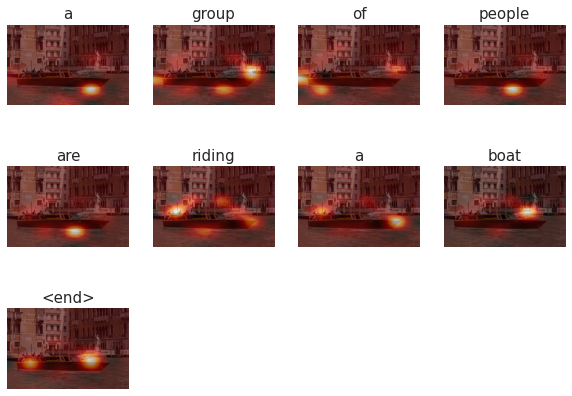

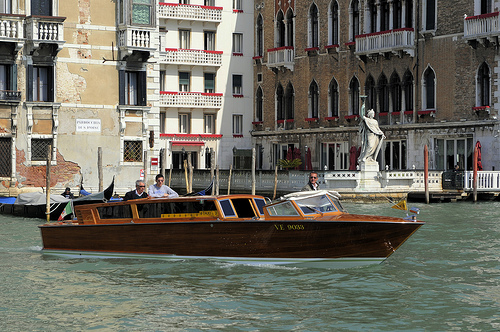

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image2 = predicted_caption_audio(len(path_test[rid]),True)
Image.open(test_image2)

#### Image 3

Type= 1-Gram, Weight=(1, 0, 0, 0), Score=0.2791881675133095
Type= 2-Gram, Weight=(0, 1, 0, 0), Score=0.10857317625517594
Type= 3-Gram, Weight=(0, 0, 1, 0), Score=1.4495000173229606e-308
Type= 4-Gram, Weight=(0, 0, 0, 1), Score=1.4495000173229606e-308
Type=Random-1, Weight=(0.5, 0.5, 0, 0), Score=0.17410441154600917

Best weight type=  1-Gram
Best weight= (1, 0, 0, 0)
Best BLEU score (in%): 27.91881675133095

Real Caption: two dogs fight over a stick in a flooded field
Prediction Caption: two dogs are running in the grass


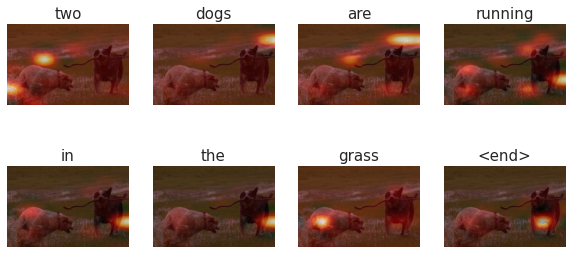

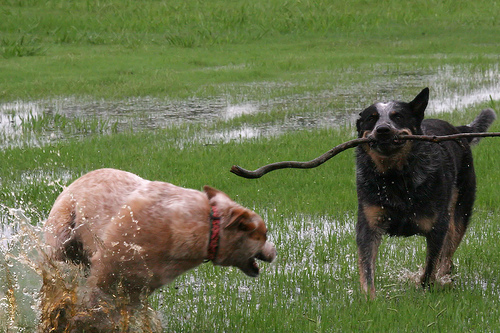

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image3 = predicted_caption_audio(len(path_test[rid]),True)
Image.open(test_image3)

#### Image 4

Type= 1-Gram, Weight=(1, 0, 0, 0), Score=0.2021768865708778
Type= 2-Gram, Weight=(0, 1, 0, 0), Score=1.3495755153097447e-308
Type= 3-Gram, Weight=(0, 0, 1, 0), Score=1.3495755153097447e-308
Type= 4-Gram, Weight=(0, 0, 0, 1), Score=1.3495755153097447e-308
Type=Random-1, Weight=(0.5, 0.5, 0, 0), Score=5.223533056060786e-155

Best weight type=  1-Gram
Best weight= (1, 0, 0, 0)
Best BLEU score (in%): 20.21768865708778

Real Caption: skateboarder on the gray steps on a large building
Prediction Caption: a skateboarder in a red shirt


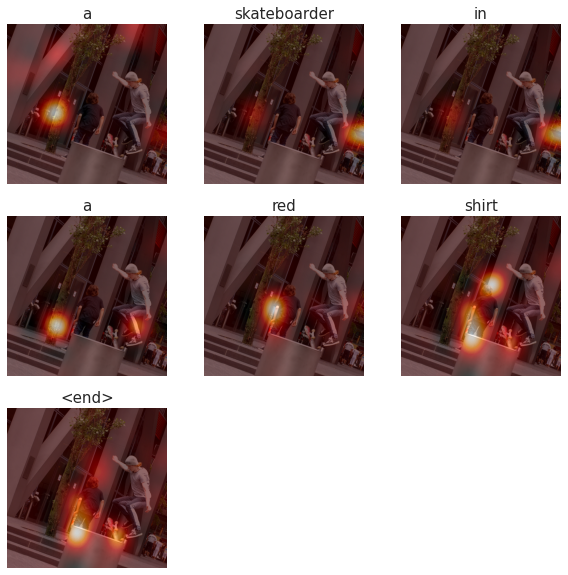

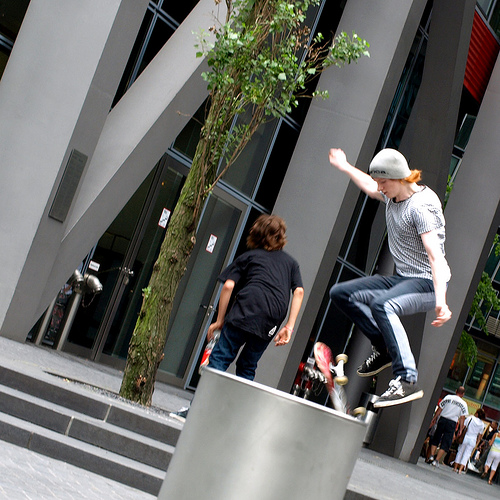

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image4 = predicted_caption_audio(len(path_test[rid]),True)
Image.open(test_image4)

#### Image 5

Type= 1-Gram, Weight=(1, 0, 0, 0), Score=0.2029077920989686
Type= 2-Gram, Weight=(0, 1, 0, 0), Score=0.04637892390833567
Type= 3-Gram, Weight=(0, 0, 1, 0), Score=7.223757182189463e-309
Type= 4-Gram, Weight=(0, 0, 0, 1), Score=7.223757182189463e-309
Type=Random-1, Weight=(0.5, 0.5, 0, 0), Score=0.09700847926942499

Best weight type=  1-Gram
Best weight= (1, 0, 0, 0)
Best BLEU score (in%): 20.290779209896858

Real Caption: a brown and white dog runs beside a wooden fence with a tennis ball in his mouth
Prediction Caption: a brown dog is running on a ball


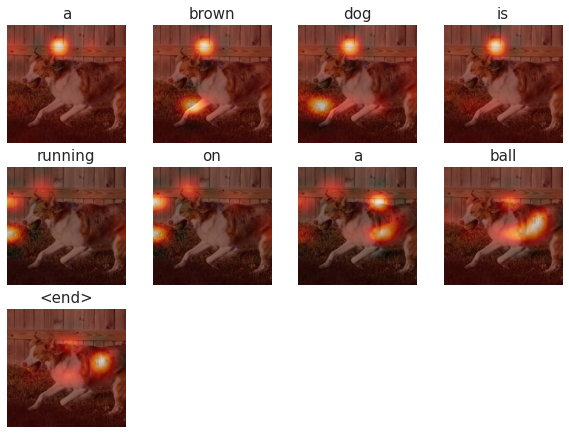

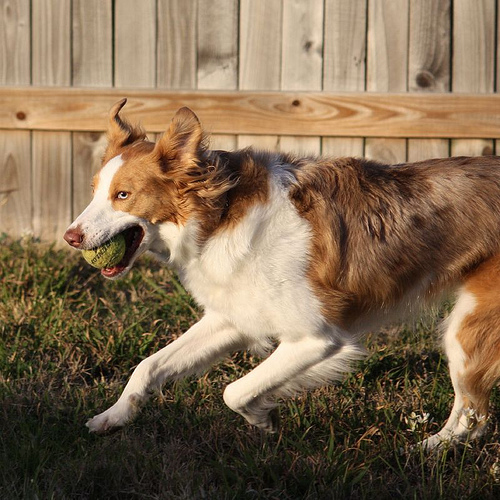

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image5 = predicted_caption_audio(len(path_test[rid]),True)
Image.open(test_image5)

#### Image 6

Type= 1-Gram, Weight=(1, 0, 0, 0), Score=0.252779610326865
Type= 2-Gram, Weight=(0, 1, 0, 0), Score=0.0695143928398879
Type= 3-Gram, Weight=(0, 0, 1, 0), Score=1.54674658298039e-308
Type= 4-Gram, Weight=(0, 0, 0, 1), Score=1.54674658298039e-308
Type=Random-1, Weight=(0.5, 0.5, 0, 0), Score=0.13255874597390954

Best weight type=  1-Gram
Best weight= (1, 0, 0, 0)
Best BLEU score (in%): 25.277961032686502

Real Caption: people in a school with a boy in the foreground wearing yellow and brown stripes
Prediction Caption: a man in a red shirt is standing in a crowd


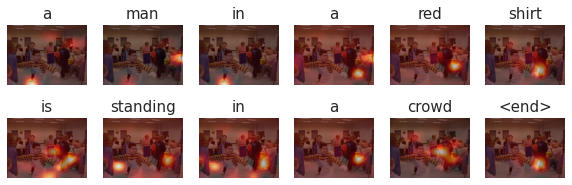

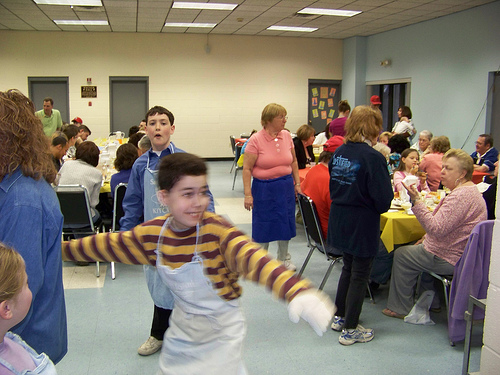

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image6 = predicted_caption_audio(len(path_test[rid]),True)
Image.open(test_image6)

#### Image 7

Type= 1-Gram, Weight=(1, 0, 0, 0), Score=0.2635971381157267
Type= 2-Gram, Weight=(0, 1, 0, 0), Score=0.15815828286943603
Type= 3-Gram, Weight=(0, 0, 1, 0), Score=0.06589928452893168
Type= 4-Gram, Weight=(0, 0, 0, 1), Score=5.86523101198632e-309
Type=Random-1, Weight=(0.5, 0.5, 0, 0), Score=0.20418146520602917

Best weight type=  1-Gram
Best weight= (1, 0, 0, 0)
Best BLEU score (in%): 26.35971381157267

Real Caption: a brown haired boy in swim trunks is flipped backwards over a swimming pool
Prediction Caption: a boy in a swimming pool


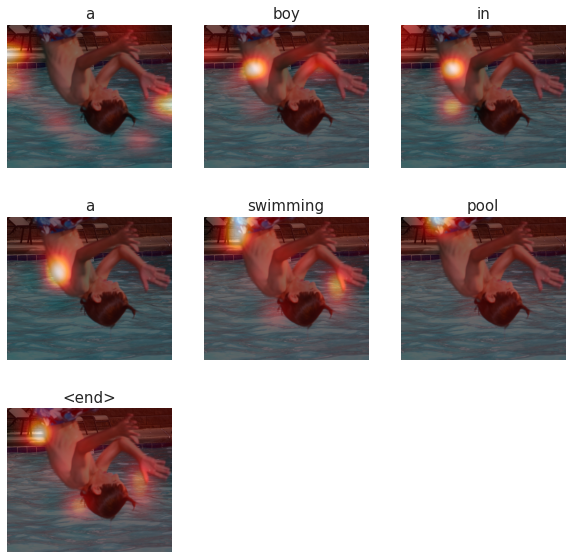

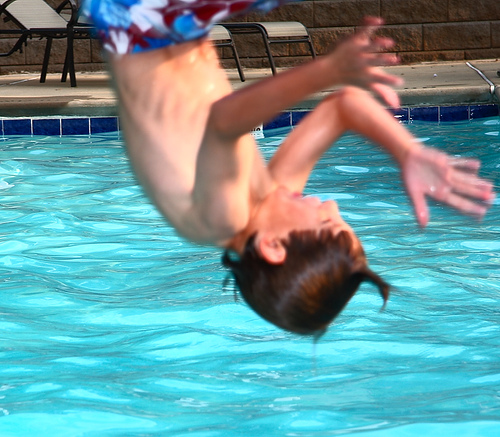

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image7 = predicted_caption_audio(len(path_test[rid]),True)
Image.open(test_image7)

#### Image 8

Type= 1-Gram, Weight=(1, 0, 0, 0), Score=0.26812801841425576
Type= 2-Gram, Weight=(0, 1, 0, 0), Score=1.491511611267286e-308
Type= 3-Gram, Weight=(0, 0, 1, 0), Score=1.491511611267286e-308
Type= 4-Gram, Weight=(0, 0, 0, 1), Score=1.491511611267286e-308
Type=Random-1, Weight=(0.5, 0.5, 0, 0), Score=6.3238916243951906e-155

Best weight type=  1-Gram
Best weight= (1, 0, 0, 0)
Best BLEU score (in%): 26.812801841425575

Real Caption: child wearing a hat at the beach
Prediction Caption: a boy in a beach


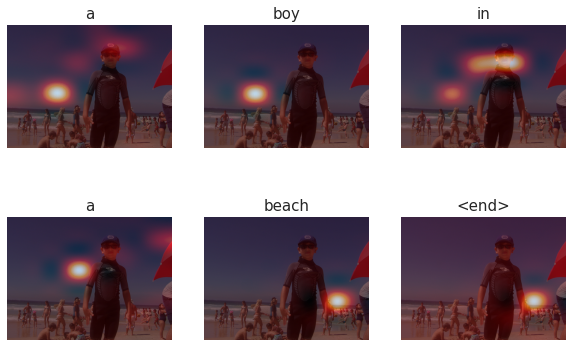

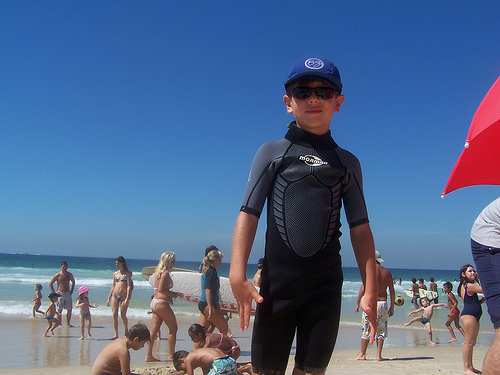

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image8 = predicted_caption_audio(len(path_test[rid]),True)
Image.open(test_image8)

### **8.2 Beam Search (Optional)**

>* The alternative for greedy search is beam search. 
>* In beam search, the model finds the k most likely words instead of selecting a single word and these k words are passed on to the next timestamp. 
>* It works on the breadth-first search algorithm.

In [ ]:
# Here we are using 64 cause when we Extract features we get shape (1, 8, 8, 2048) pre image, 
# and we need to reshape to (1, 8*8, 2048); so 8*8=64
attention_features_shape = 64
max_sequence_len = 39 #max_seq_length # 39

In [ ]:
def beam_evaluate(image, beam_index =3):

    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_the_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_sequence_len:
        temp = []
        for i, s in enumerate(result):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

#### Image 1 (Beam Search)

a black in playing



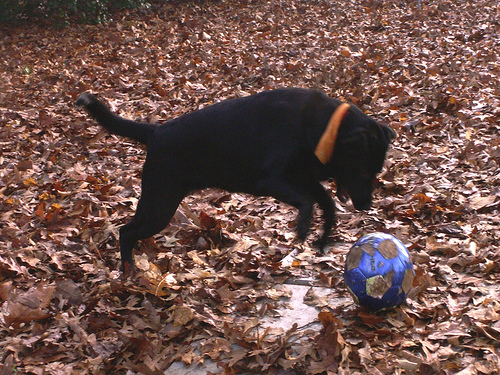

In [ ]:
# test_image = path_test[78]
rid = np.random.randint(0, len(path_test))
test_image1 = path_test[rid]

captions=beam_evaluate(test_image1)
print(captions+"\n")
Image.open(test_image1)

#### Image 2 (Beam Search)

three men on a red shirt is jumping on



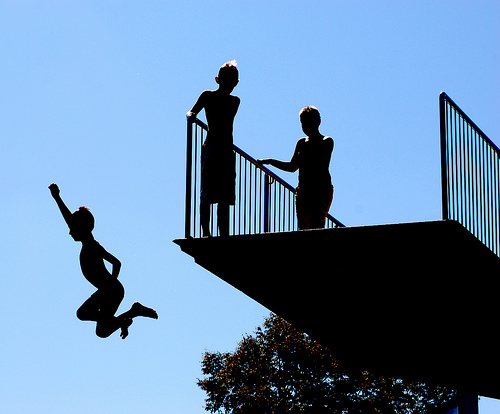

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image2 = path_test[rid]

captions=beam_evaluate(test_image2)
print(captions+"\n")
Image.open(test_image2)

#### Image 3 (Beam Search)

a small boy on a toy



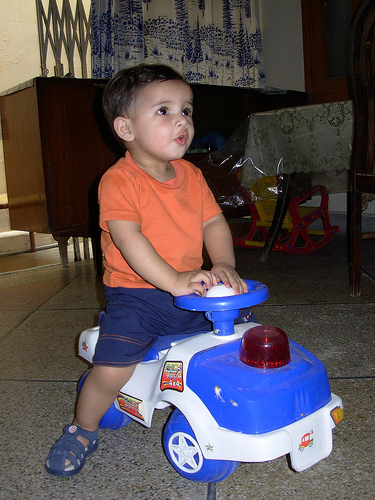

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image3 = path_test[rid]

captions=beam_evaluate(test_image3)
print(captions+"\n")
Image.open(test_image3)